# 导入模块

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns 
#sns.set(style="darkgrid")
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False


from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
import time

import warnings  
warnings.filterwarnings("ignore")

import sys
import pymysql
from sqlalchemy import create_engine
import json
import datetime 
from datetime import timedelta ,datetime
import re
import gc

import os
import sys
# 获取当前工作目录
current_dir = os.getcwd()
# 将模块所在的目录添加到 sys.path
module_dir = os.path.join(current_dir, '../Class_Model')
sys.path.append(module_dir)
from All_Class import All_Model, Week_Model, Data_Clean

pd.set_option('display.max_columns', None)
# 实例化All_Model类
all_models = All_Model()
week_models = Week_Model()
clean = Data_Clean()

# 导入订单数据

In [7]:
def select_data():
    sql1 = ''' -- 订单&风控信息  近10日数据   
    SELECT date(om.create_time) as create_date,om.create_time,om.id as order_id ,om.order_number,om.all_money 
    ,om.status, om.user_id
    ,case om.`status` when  1 then "待支付" when  2 then "待发货" when  3 then "待收货" when  4 then "租赁中" when  5 then "待归还" 
    when  6 then "待商家收货" when  7 then "退押中" when  8 then "已完成" when  10 then "已退款" when  11 then "待退押金" when  12 then "待审核" 
    when  13 then "订单取消" when  15 then "检测中" when  9999 then "逾期订单" end as status2 
    ,case when locate('租物',pa.name)>0 or locate('租物',cc.name)>0 or locate('芝麻',pa.name)>0 or locate('芝麻',cc.name)>0  then '芝麻租物' when locate('抖音',pa.name)>0 then '抖音渠道' when locate('搜索',cc.name)>0 then '搜索渠道' else '其他渠道' end as channel_type 
    ,tod.sku_attributes,tod.product_name,tod.new_actual_money, tod.product_id
    ,case when  locate('租完即送',tod.sku_attributes)>0 then '租完即送' else '租物归还' end as back_type
    ,om.user_mobile,tmu.true_name,tmu.id_card_num
    ,top.total_describes,tor.decision_result,om.cancel_reason
    ,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.traceid') end,'"','') as trace_id 
    ,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.rejected') end,'"','') as rejected 
    ,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.result') end,'"','') as result 
    ,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.tips') end,'"','') as tips  
    ,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.is_vip') end,'"','') as is_vip
    ,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.status') end,'"','') as status_result
    ,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.queue_verify_type') end,'"','') as qvt_risk
    ,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.queue_verify_type') end,'"','') as qvt_result
    ,cc.name as channel_name         -- 来源渠道
    ,cc.channel_type_id              -- 渠道id
    ,pa.name as activity_name        -- 活动名称
    ,om.merchant_id,om.merchant_name
    ,topay.total_freeze_fund_amount , tod.dy_order_item_json, pa.type
    ,om.buy_service_product,tso.status as service_status 
    ,om.order_method, om.activity_id, om.appid, tprm.max_overdue_days
    ,tor.update_time, tomt.reason, tprm.purchase_amount, tprm.liquidated_damages 违约金
    ,om.order_type, om.union_rent_tag, tojo.app_type, tprm.rent_received 已收租金 
    ,tolog.status 物流状态
    ,replace(case when JSON_VALID(risk.data) THEN JSON_EXTRACT(risk.data, '$.rejected_ato_risk') end,'"','') as rejected_ato_risk
    ,tp.classify_id, tpmn.name 机型
    from db_digua_business.t_order  om
    left join db_digua_business.t_postlease_receivables_monitoring tprm on tprm.order_id=om.id
    left join db_digua_business.t_order_risk tor on om.id = tor.order_id
    -- 备注信息合并 
    left join ( SELECT  t.order_id,JSON_ARRAYAGG(t.describes) as total_describes from db_digua_business.t_order_personnel t   GROUP BY 1 ) top 
    on om.id = top.order_id 
    -- 服务信息
    left join  db_digua_business.t_service_order tso  on om.id = tso.order_id 
    -- 渠道名称
    left join db_digua_business.t_channel cc on om.channel = cc.scene 
    -- 活动名称
    left join db_digua_business.t_platform_activity pa on om.activity_id = pa.id
    -- 用户信息 
    left join db_digua_business.t_member_user tmu on om.user_id = tmu.id
    -- 商品信息
    left join db_digua_business.t_order_details tod on om.id = tod.order_id
    -- 免押信息  
    left join (SELECT t.*,row_number() over(partition by t.order_id order by t.pay_date desc) as rn 
    from db_digua_business.t_order_pay t 

    where t.pay_type = 'ZFBYSQ' and t.item_type=1 and t.`status` in (2,5) and t.trade_no is not null )  topay 
    on topay.order_id=om.id   and  topay.rn = 1 
    -- 商家订单转移表
    left join db_digua_business.t_order_merchant_transfer tomt on tomt.order_id=om.id
    -- 京东外部订单关联表
    left join db_digua_business.t_order_jd_out_no tojo on tojo.order_id=om.id
    -- 订单物流表
    left join db_digua_business.t_order_logistics tolog on tolog.order_id=om.id
    -- 租后分期表
    -- left join db_rent.ya_merchant_order_stages ymos on ymos.order_id=om.id
    left join db_credit.risk risk on risk.order_id=om.id
    -- 商品表
    left join db_digua_business.t_product tp on tp.id=tod.product_id -- 8942.97MB

    left join db_digua_business.t_product_model_number tpmn on tpmn.id=tp.model_number_id


    where om.user_mobile is not null 
    and tmu.true_name not in ("刘鹏","谢仕程","潘立","洪柳","陈锦奇","周杰","卢腾标","孔靖","黄娟","钟福荣","邱锐杰","唐林华"
    ,"邓媛斤","黄子南","刘莎莎","赖瑞彤","孙子文",'张娜','罗文龙','孔靖','彭康力','何薪华','夏玥','潘佳','包闻天','方全龙','李楠','向圆圆','黄兰娟','林婉婷','廖丽敏','李巧玲','李巧凤','刘三妹','蔡斯静','陈宜诗','陈宝易','林寅钗','谢金凤','刘宏生','骆昌鑫','何静', '李珍珍')
    and  om.create_time >= CURDATE()             -- 近20天数据
    and  om.create_time < DATE_ADD(CURDATE() ,INTERVAL 1 day )
    -- and  DATE_FORMAT(om.create_time, '%Y-%m-%d')>='2025-10-20'
    -- and  DATE_FORMAT(om.create_time, '%Y-%m-%d')='2025-10-27'
    -- and TIME(om.create_time) <= '17:30:00'
    '''
    
    sql3 = '''
    SELECT id_card, time, replace(case when JSON_VALID(data) THEN JSON_EXTRACT(data, '$.status') end,'"','') as status   FROM `db_credit`.risk_examine
    '''

    df_order = clean.query(sql1)
    df_risk_examine = clean.query(sql3)
    
    return df_order, df_risk_examine

In [8]:
# sql3 = '''
# SELECT id_card, time, replace(case when JSON_VALID(data) THEN JSON_EXTRACT(data, '$.status') end,'"','') as status   FROM `db_credit`.risk_examine
# '''
# # df_risk_examine = clean.query(sql3)

# 数据处理

In [9]:
def process_data(df_order):
    # 复制数据
    df = df_order.copy()
    # df = df[df.type!=4]
    
    # 处理日期
    df["下单日期"]=df["create_time"].dt.date
    df["下单日期"]=pd.to_datetime(df["下单日期"],errors="coerce")
    print(df["下单日期"].unique())
    df["月份"]=df["下单日期"].dt.month
    df["下单月份"]=df["create_time"].dt.strftime('%Y-%m')
    df['年份'] = df["下单日期"].dt.year
    df['hour'] = df['create_time'].dt.hour
    
    # 处理备注信息
    df = df[df['sku_attributes'].notnull()]
    df['拒绝理由'] = df["rejected"].str.replace("[","").str.replace("]","").str.replace('"','')
    # 确保 total_describes 列为字符串类型
    df["total_describes"] = df["total_describes"].astype(str).fillna("")
    # 暂时修改一下，由于 AttributeError: Can only use .str accessor with string values! 错误
    # df["取消原因"]=df["total_describes"].str.split("客户申请取消：").str[1].str.split("$").str[0].str.strip()
    # df["电审拒绝原因"]=df["total_describes"].str.split("审核不通过：").str[1].str.split("$").str[0].str.strip()
    # df["无法联系原因"]=df["total_describes"].str.split("用户无法联系：").str[1].str.split("$").str[0].str.strip()
    
    # 更安全的处理方式
    df["取消原因"] = df["total_describes"].apply(lambda x: x.split("客户申请取消：")[1].split("$")[0].strip() if "客户申请取消：" in x and len(x.split("客户申请取消：")) > 1 else None)
    df["电审拒绝原因"] = df["total_describes"].apply(lambda x: x.split("审核不通过：")[1].split("$")[0].strip() if "审核不通过：" in x and len(x.split("审核不通过：")) > 1 else None)
    df["无法联系原因"] = df["total_describes"].apply(lambda x: x.split("用户无法联系：")[1].split("$")[0].strip() if "用户无法联系：" in x and len(x.split("用户无法联系：")) > 1 else None)
    
    
    df.loc[:,"商品类型"]=np.where(df["product_name"].str.contains('99新')|df["product_name"].str.contains('95新')|df["product_name"].str.contains('准新'),"二手","全新")  ##  准新
    df.loc[:,"租赁方案"]=np.where(df["sku_attributes"].str.contains('租完即送'),"租完即送","租完归还")
    df.loc[:,"押金类型"]=np.where(df["total_freeze_fund_amount"]>0,"部分免押","全免押")
    df.loc[:,"优惠券使用否"]=np.where((df["new_actual_money"]-df["all_money"]>0)&(df["租赁方案"]=='租完即送'),"已使用","未使用")
    df.loc[:,"是否进行预授权"]=np.where(df["total_freeze_fund_amount"].isnull(),"未预授权","已预授权")

    # 处理备注信息
    # df['取消原因2'] = df['cancel_reason'].str.split('：').apply(lambda x: x[-1] if x is not None else x)
    def getcolor(s):
        color_list=json.loads(s)
        for j in range(0,len(color_list)):
            if color_list[j]["key"]=="颜色":
                return color_list[j]["value"]
    df.loc[:,"颜色"]=df.apply(lambda x:getcolor(x["sku_attributes"]),axis=1)


    def getneicun(s):
        color_list=json.loads(s)
        for j in range(0,len(color_list)):
            if color_list[j]["key"]=="内存":
                return color_list[j]["value"]

    df.loc[:,"内存"]=df.apply(lambda x: getneicun(x["sku_attributes"]),axis=1)
    def getfangan(s):
        color_list=json.loads(s)
        for j in range(0,len(color_list)):
            if color_list[j]["key"]=="租赁方案":
                return color_list[j]["value"]
    df.loc[:,"租赁方案"]=df.apply(lambda x:getfangan(x["sku_attributes"]),axis=1)

    df.loc[:,"进件"]=np.where((df["status2"]=="待支付")|(df["status2"]=="订单取消"),"未进件","进件")


    df.loc[:,"来源渠道"]=df["channel_name"].fillna("未知渠道")
    df.loc[:,"退货拒签"] = np.where(df['物流状态']==5, 1, 0)
    df.loc[:,'机型内存'] = df['机型'] +'_'+ df['内存']
    df.loc[:, '机型内存颜色'] = df['机型'] +'_'+ df['内存'] +'_'+ df['颜色']
    
    df['免审'] = np.where(df.decision_result.str.contains(pat='免人审',regex=False),1,0)
    
    df.loc[:,"归属渠道"]=df.apply(lambda x: clean.qudao_type(x["来源渠道"],x["activity_name"],x["order_method"], x['channel_type_id'], x['order_type']),axis=1)
    
    # 订单去重
    df = clean.order_drop_duplicates(df)
    
    # 定义状态
    df['是否前置拦截'] = np.where((df.result.str.contains('id_card不得为空') )|(df.result.str.contains('mobile校验不通过')) |(df.result.str.contains('name校验不通过'))
                        |(df.result.str.contains('年龄超过49岁或低于18岁'))|(df.result=='风控未通过')|(df.result=='黑名单用户'),1,0)
    df['是否机审强拒'] = np.where((df.result.str.contains('风控拒绝') & (~df.result.str.contains('命中出库前风控流强拒').fillna(False)) ),1,0)
    df['是否出库前风控强拒'] = np.where((df.result.str.contains('命中出库前风控流强拒').fillna(False)) |((df.total_describes.str.contains('蚂蚁数控风险等级').fillna(False)) & (~df.result.str.contains('黑名单用户').fillna(False))) ,1,0)
    
    df.loc[:,"审核状态"]=df.apply(lambda x: clean.reject_type(x["拒绝理由"],x["进件"],x["电审拒绝原因"],x["取消原因"],x["status2"],x["无法联系原因"],x["total_describes"],x['是否前置拦截'],x['是否机审强拒'],x['是否出库前风控强拒']),axis=1)#,x["无法联系原因"]
    
    # 保留、剔除商家数据
    df_contain = df.copy()
    df = clean.drop_merchant(df)
    # 去重订单明细导出
    # today = datetime.today() 
    # t_date = today.date().strftime('%Y-%m-%d')
    
    df_j = df[df["进件"]=="进件"]
    
    df = clean.status_node(df)
    
    # 剔除拒量订单
    df2 = df.copy()
    df2 = clean.drop_rejected_merchant(df2)
    df2 = df2[df2.是否拒量==0]
    day_name_cn_mapping = {
        'Monday': '星期一',
        'Tuesday': '星期二',
        'Wednesday': '星期三',
        'Thursday': '星期四',
        'Friday': '星期五',
        'Saturday': '星期六',
        'Sunday': '星期日'
    }
    
    return df, df2

# iPhone16,17系列 定时任务

In [11]:
# iPhone16系列、iPhone17系列占比情况更新
# 机型+内存+渠道（支付宝、京东）+进件+出库+进件占比+出库占比，
# 每日数据更新 至17预租数据文件内。
from apscheduler.schedulers.blocking import BlockingScheduler
from apscheduler.schedulers.background import BackgroundScheduler
def myjob2():
    minute = 35
    path = r'\\digua\迪瓜租机\18.iPhone17预租数据/'
    Today = str(datetime.now().strftime('%Y%m%d%H'))
    print(f'执行定时任务：现在是{Today}的{minute}分')
    
    df_order, df_risk_examine = select_data()
    print(df_order.shape)
    
    # 数据处理
    df, df2 = process_data(df_order)
    df.loc[:, '订单渠道'] = np.where(df['order_type']=='ZFB_ORDER', '支付宝', df['归属渠道'])
    df2.loc[:, '订单渠道'] = np.where(df2['order_type']=='ZFB_ORDER', '支付宝', df2['归属渠道'])
    df.loc[:, 'iPhone系列'] = np.where(df['product_name'].str.contains(r'iPhone 16|iPhone16'), 'iPhone16系列', 
                                    np.where(df['product_name'].str.contains(r'iPhone 17|iPhone Air|iPhone17'),'iPhone17系列', '其他系列'))
    df2.loc[:, 'iPhone系列'] = np.where(df2['product_name'].str.contains(r'iPhone 16|iPhone16'), 'iPhone16系列', 
                                    np.where(df2['product_name'].str.contains(r'iPhone 17|iPhone Air|iPhone17'),'iPhone17系列', '其他系列'))
    # 筛选支付宝和京东的数据
    # df2.loc[:, 'iPhone系列'] = np.where(df2['机型'].str.contains(r'iPhone 16|iPhone16'), 'iPhone16系列', 'iPhone17系列')
    
    # 筛选支付宝和京东的数据
    df = df[(df['order_type']=='ZFB_ORDER')|(df['归属渠道']=='京东渠道')]
    df2 = df2[(df2['order_type']=='ZFB_ORDER')|(df2['归属渠道']=='京东渠道')]
    
    # 筛选iphone16系列数据
    df_iphone16 = df[df.product_name.str.contains(r'iPhone 16|iPhone16')]
    # df_iphone16_2 = df2[df2.product_name.str.contains(r'iPhone 16|iPhone16')]
    # df_iphone16_group = all_models.data_group(df_iphone16, df_iphone16_2, df_risk_examine, ['机型内存', '订单渠道'])
    # df_iphone16_group = df_iphone16_group[['进件数', '出库']]
    df_iphone16_group = df_iphone16.groupby(['机型内存', '订单渠道']).agg({'是否进件': 'sum', '是否出库':'sum'}).rename(columns={'是否进件': '进件数', '是否出库':'出库'})
    # 计算进件占比与出库占比
    df_iphone16_group.loc[:, '进件占比'] = df_iphone16_group['进件数'] / df_iphone16_group['进件数'].sum()
    df_iphone16_group.loc[:, '进件占比'] = df_iphone16_group['进件占比'].apply(lambda x:format(x,".2%"))
    df_iphone16_group.loc[:, '出库占比'] = df_iphone16_group['出库'] / df_iphone16_group['出库'].sum()
    df_iphone16_group.loc[:, '出库占比'] = df_iphone16_group['出库占比'].apply(lambda x:format(x,".2%"))
    df_iphone16_group_new = df_iphone16_group.reset_index()
    df_iphone16_group_new.loc['合计'] = df_iphone16_group_new.select_dtypes(include=[np.number]).sum()
    
    
    #iphone 17系列转化数据，总体
    df_iphone17 = df[df['product_name'].str.contains(r'iPhone 17|iPhone Air|iPhone17')]
    df_iphone17_2 = df2[df2['product_name'].str.contains(r'iPhone 17|iPhone Air|iPhone17')]
    df_iphone17_group = df_iphone17.groupby(['机型内存', '订单渠道']).agg({'是否进件': 'sum', '是否出库':'sum'}).rename(columns={'是否进件': '进件数', '是否出库':'出库'})
    # df_iphone17_group = df_iphone17.groupby('机型内存颜色').agg({'是否进件': 'sum', '是否出库':'sum'}).rename(columns={'是否进件': '进件数', '是否出库':'出库'})
    # df_iphone17_group = all_models.data_group(df_iphone17, df_iphone17_2, df_risk_examine, ['机型内存', '订单渠道'])
    # df_iphone17_group = df_iphone17_group[['进件数', '出库']]
    # 计算进件占比与出库占比
    df_iphone17_group.loc[:, '进件占比'] = df_iphone17_group['进件数'] / df_iphone17_group['进件数'].sum()
    df_iphone17_group.loc[:, '进件占比'] = df_iphone17_group['进件占比'].apply(lambda x:format(x,".2%"))
    df_iphone17_group.loc[:, '出库占比'] = df_iphone17_group['出库'] / df_iphone17_group['出库'].sum()
    df_iphone17_group.loc[:, '出库占比'] = df_iphone17_group['出库占比'].apply(lambda x:format(x,".2%"))
    df_iphone17_group_new = df_iphone17_group.reset_index()
    df_iphone17_group_new.loc['合计'] = df_iphone17_group_new.select_dtypes(include=[np.number]).sum()
    
    df_iphone = df[(df['product_name'].str.contains(r'iPhone 16|iPhone16'))|(df['product_name'].str.contains(r'iPhone 17|iPhone Air|iPhone17'))]
    # df_iphone_2 = df2[(df2['机型'].str.contains(r'iPhone 16|iPhone16'))|(df2['机型'].str.contains(r'iPhone 17|iPhone Air'))]
    # df_iphone_all = all_models.data_group(df_iphone, df_iphone_2, df_risk_examine, ['iPhone系列', '订单渠道'])
    # df_iphone_all = df_iphone_all[['进件数', '出库']]
    df_iphone_all = df_iphone.groupby(['iPhone系列', '订单渠道']).agg({'是否进件': 'sum', '是否出库':'sum'}).rename(columns={'是否进件': '进件数', '是否出库':'出库'})
    df_iphone_all.loc[:, '进件占比'] = df_iphone_all['进件数'] / df_iphone_all['进件数'].sum()
    df_iphone_all.loc[:, '进件占比'] = df_iphone_all['进件占比'].apply(lambda x:format(x,".2%"))
    df_iphone_all.loc[:, '出库占比'] = df_iphone_all['出库'] / df_iphone_all['出库'].sum()
    df_iphone_all.loc[:, '出库占比'] = df_iphone_all['出库占比'].apply(lambda x:format(x,".2%"))
    df_iphone_all_new = df_iphone_all.reset_index()
    df_iphone_all_new.loc['合计'] = df_iphone_all_new.select_dtypes(include=[np.number]).sum()
    
    
    with pd.ExcelWriter(path + f'iPhone 16-17系列占比_{Today}.xlsx', engine='openpyxl') as writer:
        df_iphone16_group_new.to_excel(writer, sheet_name='iPhone16系列占比', index=True)
        df_iphone17_group_new.to_excel(writer, sheet_name='iPhone17系列占比', index=True)
        df_iphone_all_new.to_excel(writer, sheet_name='iPhone16-17系列占比', index=True)
        # df_iphone_all_new.to_excel(writer, sheet_name='iPhone16-17系列周数据占比', index=True)
        
    del df_iphone16_group_new, df_iphone17_group_new, df_iphone_all_new
    gc.collect()
    print("iPhone 16、17系列占比数据已保存,内存已回收")


myjob2()
scheduler2 = BackgroundScheduler()
# 添加一个cron任务，每天的17点35分执行
scheduler2.add_job(myjob2, 'cron', hour=17, minute=35)

# 启动scheduler2
scheduler2.start()
# try:
#     # 为了保持程序持续运行，可以使用以下代码
#     while True:
#         time.sleep(1)
# except KeyboardInterrupt:
#     print("程序被用户中断")
#     scheduler2.shutdown()

执行定时任务：现在是2025103117的35分
(11440, 54)
<DatetimeArray>
['2025-10-31 00:00:00']
Length: 1, dtype: datetime64[ns]
iPhone 16、17系列占比数据已保存,内存已回收


In [ ]:
# df_order, df_risk_examine = select_data()
# # 数据处理
# df, df2 = process_data(df_order)
# df.loc[:, '订单渠道'] = np.where(df['order_type']=='ZFB_ORDER', '支付宝', df['归属渠道'])
# df2.loc[:, '订单渠道'] = np.where(df2['order_type']=='ZFB_ORDER', '支付宝', df2['归属渠道'])
# df.loc[:, 'iPhone系列'] = np.where(df['product_name'].str.contains(r'iPhone 16|iPhone16'), 'iPhone16系列', 
#                                 np.where(df['product_name'].str.contains(r'iPhone 17|iPhone Air'),'iPhone17系列', '其他系列'))
# df2.loc[:, 'iPhone系列'] = np.where(df2['product_name'].str.contains(r'iPhone 16|iPhone16'), 'iPhone16系列', 
#                                 np.where(df2['product_name'].str.contains(r'iPhone 17|iPhone Air'),'iPhone17系列', '其他系列'))
# #iphone 17系列转化数据，总体
# df_iphone17 = df[df['product_name'].str.contains(r'iPhone 17|iPhone Air')]
# df_iphone17_2 = df2[df2['product_name'].str.contains(r'iPhone 17|iPhone Air')]
# df_iphone17_group = df_iphone17.groupby(['机型内存', '订单渠道']).agg({'是否进件': 'sum', '是否出库':'sum'}).rename(columns={'是否进件': '进件数', '是否出库':'出库'})
# df_iphone17_group = df_iphone17_group[['进件数', '出库']]
# # 计算进件占比与出库占比
# df_iphone17_group.loc[:, '进件占比'] = df_iphone17_group['进件数'] / df_iphone17_group['进件数'].sum()
# df_iphone17_group.loc[:, '进件占比'] = df_iphone17_group['进件占比'].apply(lambda x:format(x,".2%"))
# df_iphone17_group.loc[:, '出库占比'] = df_iphone17_group['出库'] / df_iphone17_group['出库'].sum()
# df_iphone17_group.loc[:, '出库占比'] = df_iphone17_group['出库占比'].apply(lambda x:format(x,".2%"))
# df_iphone17_group_new = df_iphone17_group.reset_index()
# df_iphone17_group_new.loc['合计'] = df_iphone17_group_new.select_dtypes(include=[np.number]).sum()
# df_iphone17_group_new

In [ ]:
# df_iphone17_group = all_models.data_group(df_iphone17, df_iphone17_2, df_risk_examine, ['机型内存', '订单渠道'])
# df_iphone17_group = df_iphone17_group[['进件数', '出库']]
# df_iphone17_group.loc[:, '进件占比'] = df_iphone17_group['进件数'] / df_iphone17_group['进件数'].sum()
# df_iphone17_group.loc[:, '进件占比'] = df_iphone17_group['进件占比'].apply(lambda x:format(x,".2%"))
# df_iphone17_group.loc[:, '出库占比'] = df_iphone17_group['出库'] / df_iphone17_group['出库'].sum()
# df_iphone17_group.loc[:, '出库占比'] = df_iphone17_group['出库占比'].apply(lambda x:format(x,".2%"))
# df_iphone17_group_new = df_iphone17_group.reset_index()
# df_iphone17_group_new.loc['合计'] = df_iphone17_group_new.select_dtypes(include=[np.number]).sum()
# df_iphone17_group_new

In [ ]:
# df_iphone = df[(df['product_name'].str.contains(r'iPhone 16|iPhone16'))|(df['product_name'].str.contains(r'iPhone 17|iPhone Air'))]
# df_iphone_2 = df2[(df2['product_name'].str.contains(r'iPhone 16|iPhone16'))|(df2['product_name'].str.contains(r'iPhone 17|iPhone Air'))]
# df_iphone_all = all_models.data_group(df_iphone, df_iphone_2, df_risk_examine, ['iPhone系列', '订单渠道'])
# df_iphone_all = df_iphone_all[['进件数', '出库']]
# df_iphone_all.loc[:, '进件占比'] = df_iphone_all['进件数'] / df_iphone_all['进件数'].sum()
# df_iphone_all.loc[:, '进件占比'] = df_iphone_all['进件占比'].apply(lambda x:format(x,".2%"))
# df_iphone_all.loc[:, '出库占比'] = df_iphone_all['出库'] / df_iphone_all['出库'].sum()
# df_iphone_all.loc[:, '出库占比'] = df_iphone_all['出库占比'].apply(lambda x:format(x,".2%"))
# df_iphone_all_new = df_iphone_all.reset_index()
# df_iphone_all_new.loc['合计'] = df_iphone_all_new.select_dtypes(include=[np.number]).sum()
# df_iphone_all_new

# 进件出库折线图

In [ ]:

df_order, df_risk_examine = select_data()

df, df2 = process_data(df_order)
df.loc[:, '订单渠道'] = np.where(df['order_type']=='ZFB_ORDER', '支付宝', df['归属渠道'])
df.loc[:, 'iPhone系列'] = np.where(df['product_name'].str.contains(r'iPhone 16|iPhone16'), 'iPhone16系列', 
                                np.where(df['product_name'].str.contains(r'iPhone 17|iPhone Air'),'iPhone17系列', '其他系列'))


<DatetimeArray>
['2025-10-20 00:00:00']
Length: 1, dtype: datetime64[ns]


## 获取iPhone 16和iPhone 17的数据

In [ ]:
df_copy = df.copy()
df_iphone = df_copy[(df_copy['product_name'].str.contains(r'iPhone 16|iPhone16'))|(df_copy['product_name'].str.contains(r'iPhone 17|iPhone Air'))]

## 进件占比折线图

In [ ]:
# 1. 按「日期、iPhone系列、订单渠道」分组，统计进件数
daily_group = df_iphone.groupby(['下单日期', 'iPhone系列', '订单渠道'])['是否进件'].sum().reset_index()
daily_group.rename(columns={'是否进件': '进件数'}, inplace=True)

# 2. 按「日期」分组，统计当日所有iPhone的总进件数
daily_total = df_iphone.groupby(['下单日期'])['是否进件'].sum().reset_index()
daily_total.rename(columns={'是否进件': '每日总进件数'}, inplace=True)

# 3. 合并数据，计算「进件占比」
df_with_ratio = pd.merge(daily_group, daily_total, on='下单日期', how='left')
df_with_ratio['进件占比'] = df_with_ratio['进件数'] / df_with_ratio['每日总进件数']
# 提取所有唯一的下单日期并按时间排序
all_dates = sorted(pd.to_datetime(df_with_ratio['下单日期'].unique()))

In [ ]:
# 提取4个目标分组
group_jd_16 = df_with_ratio[
    (df_with_ratio['iPhone系列'] == 'iPhone16系列') & (df_with_ratio['订单渠道'] == '京东渠道')
]
group_alipay_16 = df_with_ratio[
    (df_with_ratio['iPhone系列'] == 'iPhone16系列') & (df_with_ratio['订单渠道'] == '支付宝')
]
group_jd_17 = df_with_ratio[
    (df_with_ratio['iPhone系列'] == 'iPhone17系列') & (df_with_ratio['订单渠道'] == '京东渠道')
]
group_alipay_17 = df_with_ratio[
    (df_with_ratio['iPhone系列'] == 'iPhone17系列') & (df_with_ratio['订单渠道'] == '支付宝')
]

# 将「下单日期」转为 datetime 类型（便于matplotlib绘图）
group_jd_16['下单日期'] = pd.to_datetime(group_jd_16['下单日期'])
group_alipay_16['下单日期'] = pd.to_datetime(group_alipay_16['下单日期'])
group_jd_17['下单日期'] = pd.to_datetime(group_jd_17['下单日期'])
group_alipay_17['下单日期'] = pd.to_datetime(group_alipay_17['下单日期'])

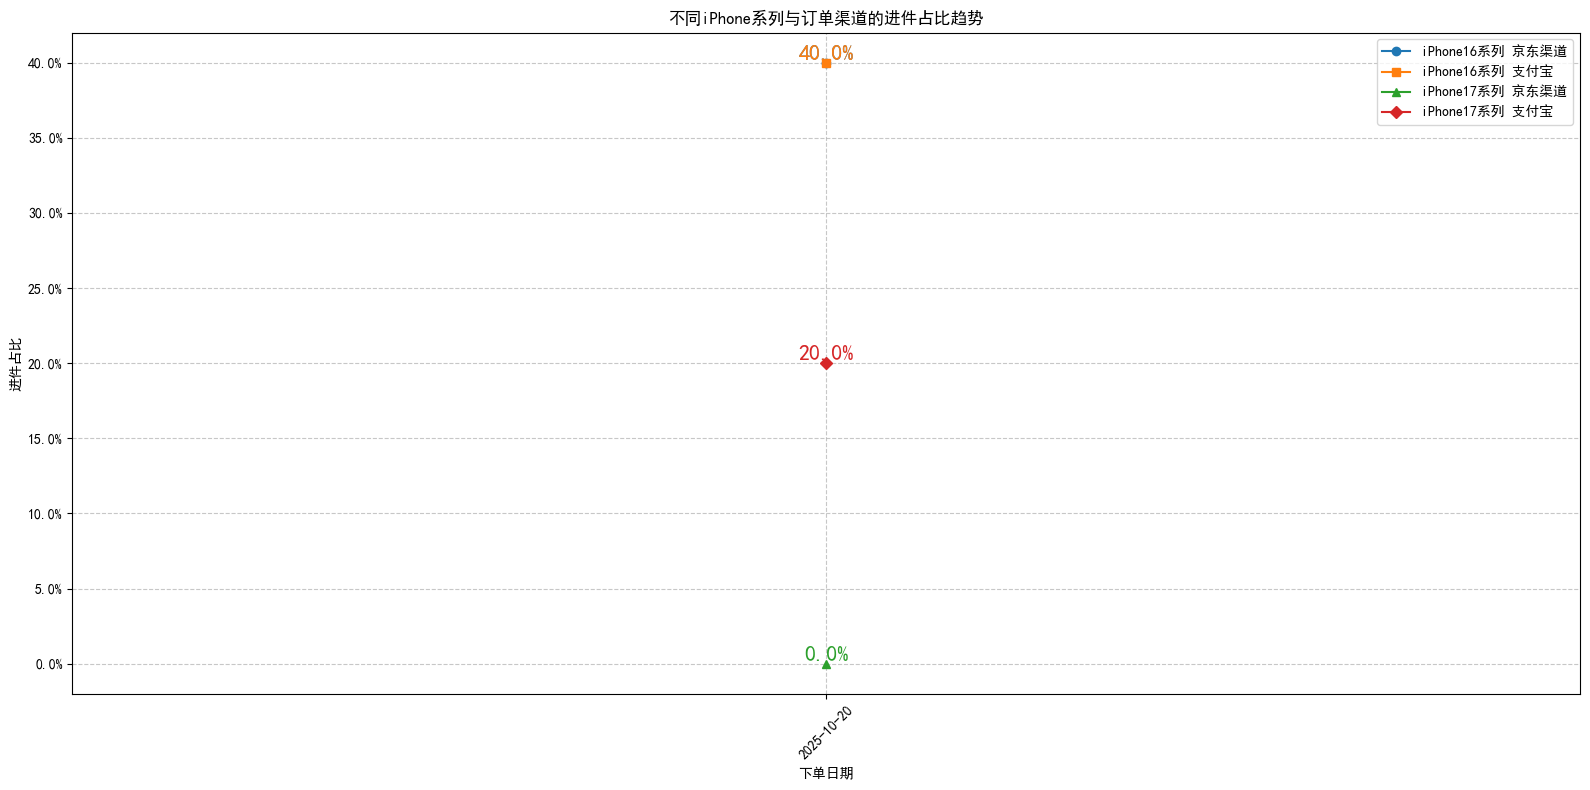

In [ ]:
from matplotlib import ticker  # 用于设置百分比刻度
plt.figure(figsize=(16, 8))  # 增大图尺寸，避免日期/标签重叠

# 绘制4条折线（分别定义line对象，用于后续标注）
line_jd16, = plt.plot(
    group_jd_16['下单日期'], group_jd_16['进件占比'], 
    marker='o', label='iPhone16系列 京东渠道'
)
line_alipay16, = plt.plot(
    group_alipay_16['下单日期'], group_alipay_16['进件占比'], 
    marker='s', label='iPhone16系列 支付宝'
)
line_jd17, = plt.plot(
    group_jd_17['下单日期'], group_jd_17['进件占比'], 
    marker='^', label='iPhone17系列 京东渠道'
)
line_alipay17, = plt.plot(
    group_alipay_17['下单日期'], group_alipay_17['进件占比'], 
    marker='D', label='iPhone17系列 支付宝'
)

# 纵坐标设置为百分比格式
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))  # xmax=1表示输入为「小数」，转成百分比

# x轴刻度设置为所有日期（旋转45°避免重叠）
plt.xticks(all_dates, rotation=45)

# 为每条折线添加「百分比数值标签」
def add_percent_labels(x_dates, y_ratios, line_obj, fmt='{:.1%}'):
    """遍历折线上的点，添加百分比标签"""
    for x, y in zip(x_dates, y_ratios):
        plt.text(
            x, y, fmt.format(y), 
            ha='center', va='bottom',  # 水平居中、垂直在点下方
            fontsize=16, color=line_obj.get_color()  # 标签颜色与折线一致
        )

add_percent_labels(group_jd_16['下单日期'], group_jd_16['进件占比'], line_jd16)
add_percent_labels(group_alipay_16['下单日期'], group_alipay_16['进件占比'], line_alipay16)
add_percent_labels(group_jd_17['下单日期'], group_jd_17['进件占比'], line_jd17)
add_percent_labels(group_alipay_17['下单日期'], group_alipay_17['进件占比'], line_alipay17)

# 图表美化
plt.xlabel('下单日期')
plt.ylabel('进件占比')
plt.title('不同iPhone系列与订单渠道的进件占比趋势')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # 自动调整布局，防止标签被截断

plt.show()

## 出库占比折线图

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


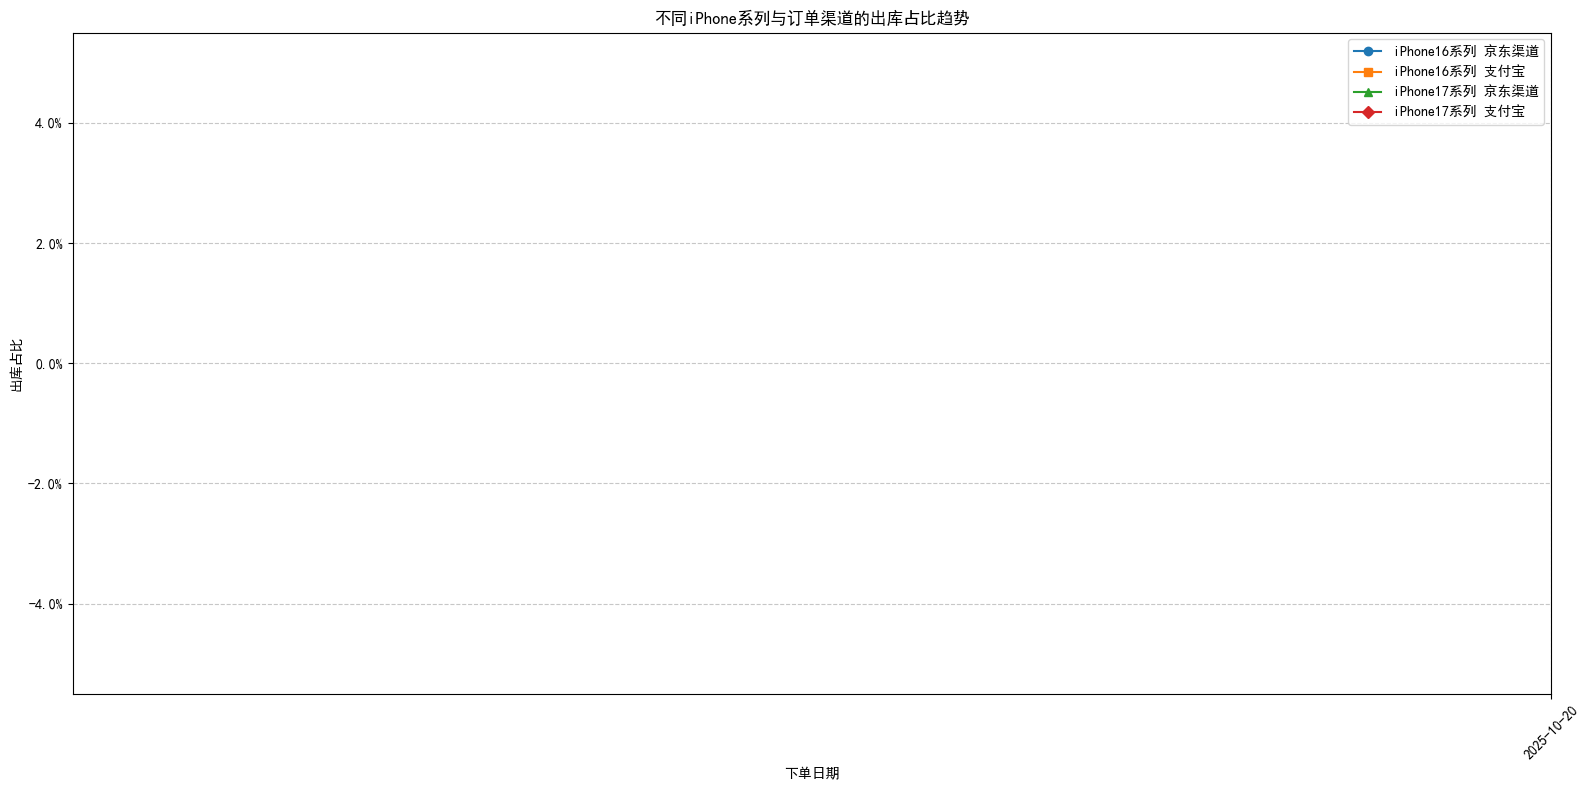

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib import ticker  # 用于百分比刻度

# # 设置中文显示
# plt.rcParams['font.sans-serif'] = ['SimHei']  
# plt.rcParams['axes.unicode_minus'] = False    


# ### 步骤1：筛选iPhone相关数据（同之前，复用筛选逻辑）
# # df_iphone = df_copy[
# #     (df_copy['product_name'].str.contains(r'iPhone 16|iPhone16', regex=True)) | 
# #     (df_copy['product_name'].str.contains(r'iPhone 17|iPhone Air', regex=True))
# # ]


# ### 步骤2：按日期/系列/渠道分组，计算「出库占比」
# # 假设数据中包含「是否出库」列（1=出库，0=未出库）
# # 1. 按「日期、iPhone系列、订单渠道」分组，统计出库数
daily_group_out = df_iphone.groupby(['下单日期', 'iPhone系列', '订单渠道'])['是否出库'].sum().reset_index()
daily_group_out.rename(columns={'是否出库': '出库数'}, inplace=True)

# 2. 按「日期」分组，统计当日所有iPhone的总出库数
daily_total_out = df_iphone.groupby(['下单日期'])['是否出库'].sum().reset_index()
daily_total_out.rename(columns={'是否出库': '每日总出库数'}, inplace=True)

# 3. 合并数据，计算「出库占比」（分组出库数 / 当日总出库数）
df_with_out_ratio = pd.merge(daily_group_out, daily_total_out, on='下单日期', how='left')
df_with_out_ratio['出库占比'] = df_with_out_ratio['出库数'] / df_with_out_ratio['每日总出库数']


### 步骤3：提取4个目标分组的出库占比数据
group_jd_16_out = df_with_out_ratio[
    (df_with_out_ratio['iPhone系列'] == 'iPhone16系列') & (df_with_out_ratio['订单渠道'] == '京东渠道')
]
group_alipay_16_out = df_with_out_ratio[
    (df_with_out_ratio['iPhone系列'] == 'iPhone16系列') & (df_with_out_ratio['订单渠道'] == '支付宝')
]
group_jd_17_out = df_with_out_ratio[
    (df_with_out_ratio['iPhone系列'] == 'iPhone17系列') & (df_with_out_ratio['订单渠道'] == '京东渠道')
]
group_alipay_17_out = df_with_out_ratio[
    (df_with_out_ratio['iPhone系列'] == 'iPhone17系列') & (df_with_out_ratio['订单渠道'] == '支付宝')
]

# 日期转为datetime类型
group_jd_16_out['下单日期'] = pd.to_datetime(group_jd_16_out['下单日期'])
group_alipay_16_out['下单日期'] = pd.to_datetime(group_alipay_16_out['下单日期'])
group_jd_17_out['下单日期'] = pd.to_datetime(group_jd_17_out['下单日期'])
group_alipay_17_out['下单日期'] = pd.to_datetime(group_alipay_17_out['下单日期'])


### 步骤4：绘制出库占比折线图（格式与进件占比一致）
# 提取所有日期（确保x轴包含全部日期）
all_dates = sorted(pd.to_datetime(df_with_out_ratio['下单日期'].unique()))

plt.figure(figsize=(16, 8))

# 绘制4条出库占比折线
line_jd16_out, = plt.plot(
    group_jd_16_out['下单日期'], group_jd_16_out['出库占比'], 
    marker='o', label='iPhone16系列 京东渠道'
)
line_alipay16_out, = plt.plot(
    group_alipay_16_out['下单日期'], group_alipay_16_out['出库占比'], 
    marker='s', label='iPhone16系列 支付宝'
)
line_jd17_out, = plt.plot(
    group_jd_17_out['下单日期'], group_jd_17_out['出库占比'], 
    marker='^', label='iPhone17系列 京东渠道'
)
line_alipay17_out, = plt.plot(
    group_alipay_17_out['下单日期'], group_alipay_17_out['出库占比'], 
    marker='D', label='iPhone17系列 支付宝'
)

# 纵坐标设置为百分比（如25.3%）
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

# x轴显示所有日期（旋转避免重叠）
plt.xticks(all_dates, rotation=45)

# 为折线上的点添加出库占比百分比标签
def add_out_percent_labels(x_dates, y_ratios, line_obj, fmt='{:.1%}'):
    for x, y in zip(x_dates, y_ratios):
        plt.text(
            x, y, fmt.format(y), 
            ha='center', va='bottom',  # 标签位置：点的正下方
            fontsize=16, color=line_obj.get_color()  # 标签颜色与折线一致
        )

add_out_percent_labels(group_jd_16_out['下单日期'], group_jd_16_out['出库占比'], line_jd16_out)
add_out_percent_labels(group_alipay_16_out['下单日期'], group_alipay_16_out['出库占比'], line_alipay16_out)
add_out_percent_labels(group_jd_17_out['下单日期'], group_jd_17_out['出库占比'], line_jd17_out)
add_out_percent_labels(group_alipay_17_out['下单日期'], group_alipay_17_out['出库占比'], line_alipay17_out)

# 图表标题与标签（替换为“出库占比”）
plt.xlabel('下单日期')
plt.ylabel('出库占比')
plt.title('不同iPhone系列与订单渠道的出库占比趋势')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## 进件数折线图

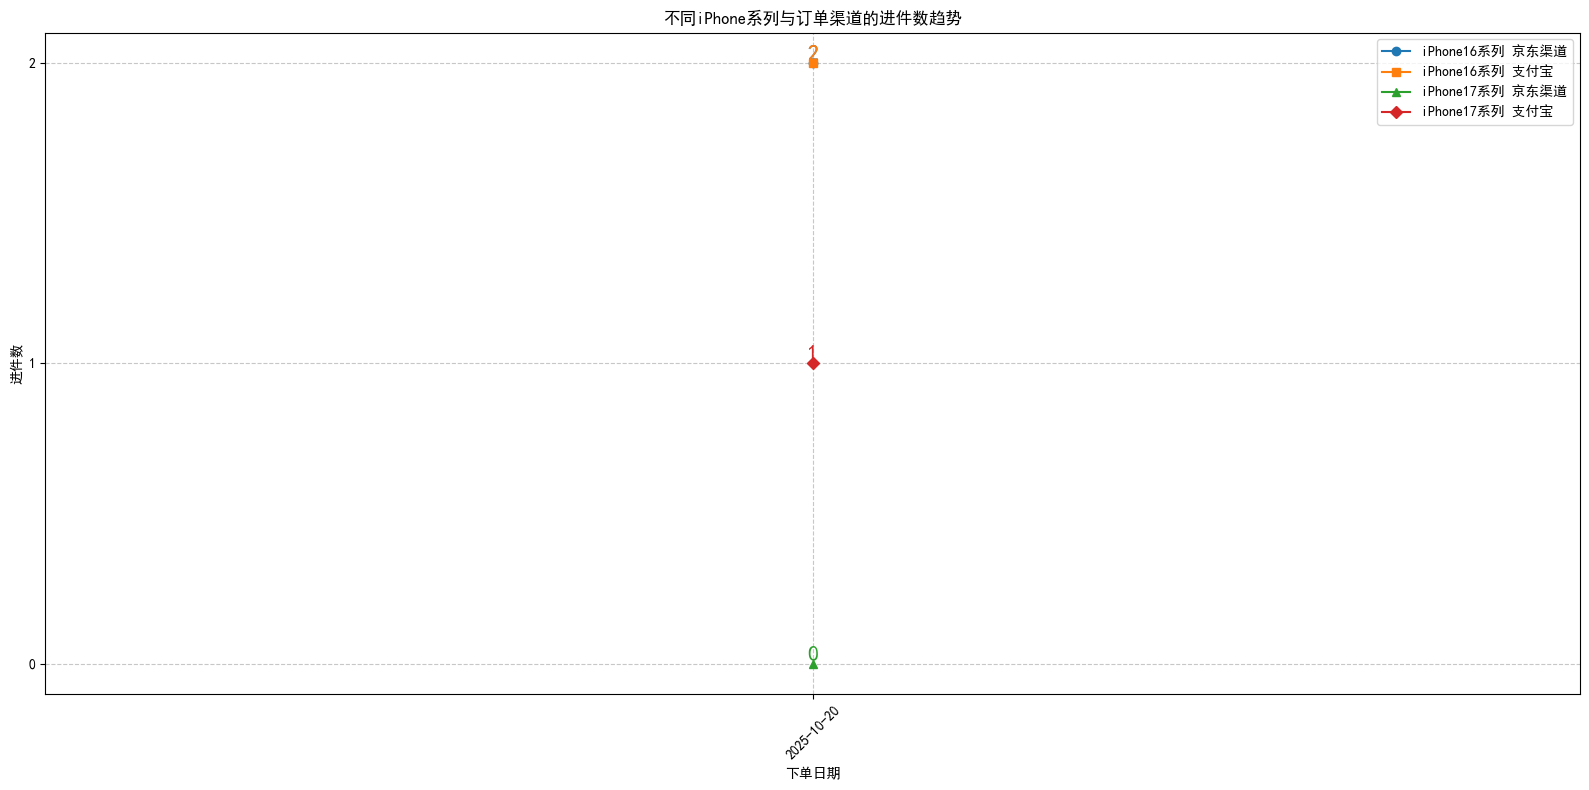

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    


### 步骤1：计算每日各分组的进件数（直接计数，非占比）
# 按「日期、iPhone系列、订单渠道」分组，统计进件数（直接求和，不计算占比）
daily_in_count = df_iphone.groupby(['下单日期', 'iPhone系列', '订单渠道'])['是否进件'].sum().reset_index()
daily_in_count.rename(columns={'是否进件': '进件数'}, inplace=True)

# 日期转为datetime类型
daily_in_count['下单日期'] = pd.to_datetime(daily_in_count['下单日期'])


### 步骤2：提取4个目标分组的进件数数据
group_jd_16_in = daily_in_count[
    (daily_in_count['iPhone系列'] == 'iPhone16系列') & (daily_in_count['订单渠道'] == '京东渠道')
]
group_alipay_16_in = daily_in_count[
    (daily_in_count['iPhone系列'] == 'iPhone16系列') & (daily_in_count['订单渠道'] == '支付宝')
]
group_jd_17_in = daily_in_count[
    (daily_in_count['iPhone系列'] == 'iPhone17系列') & (daily_in_count['订单渠道'] == '京东渠道')
]
group_alipay_17_in = daily_in_count[
    (daily_in_count['iPhone系列'] == 'iPhone17系列') & (daily_in_count['订单渠道'] == '支付宝')
]


### 步骤3：绘制进件数折线图（纵坐标为整数）
# 提取所有日期（确保x轴包含全部日期）
all_dates = sorted(pd.to_datetime(daily_in_count['下单日期'].unique()))

plt.figure(figsize=(16, 8))  # 第一个图表：进件数

# 绘制4条进件数折线
line_jd16_in, = plt.plot(
    group_jd_16_in['下单日期'], group_jd_16_in['进件数'], 
    marker='o', label='iPhone16系列 京东渠道'
)
line_alipay16_in, = plt.plot(
    group_alipay_16_in['下单日期'], group_alipay_16_in['进件数'], 
    marker='s', label='iPhone16系列 支付宝'
)
line_jd17_in, = plt.plot(
    group_jd_17_in['下单日期'], group_jd_17_in['进件数'], 
    marker='^', label='iPhone17系列 京东渠道'
)
line_alipay17_in, = plt.plot(
    group_alipay_17_in['下单日期'], group_alipay_17_in['进件数'], 
    marker='D', label='iPhone17系列 支付宝'
)

# 纵坐标设置为整数（自动适配数据范围）
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # 强制纵坐标为整数

# x轴显示所有日期
plt.xticks(all_dates, rotation=45)

# 为折线上的点添加进件数标签（整数格式）
def add_in_count_labels(x_dates, y_counts, line_obj, fmt='{:.0f}'):
    for x, y in zip(x_dates, y_counts):
        plt.text(
            x, y, fmt.format(y), 
            ha='center', va='bottom',  # 标签在点下方
            fontsize=16, color=line_obj.get_color()
        )

add_in_count_labels(group_jd_16_in['下单日期'], group_jd_16_in['进件数'], line_jd16_in)
add_in_count_labels(group_alipay_16_in['下单日期'], group_alipay_16_in['进件数'], line_alipay16_in)
add_in_count_labels(group_jd_17_in['下单日期'], group_jd_17_in['进件数'], line_jd17_in)
add_in_count_labels(group_alipay_17_in['下单日期'], group_alipay_17_in['进件数'], line_alipay17_in)

# 图表信息
plt.xlabel('下单日期')
plt.ylabel('进件数')
plt.title('不同iPhone系列与订单渠道的进件数趋势')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()  # 显示进件数图表

## 出库数折线图

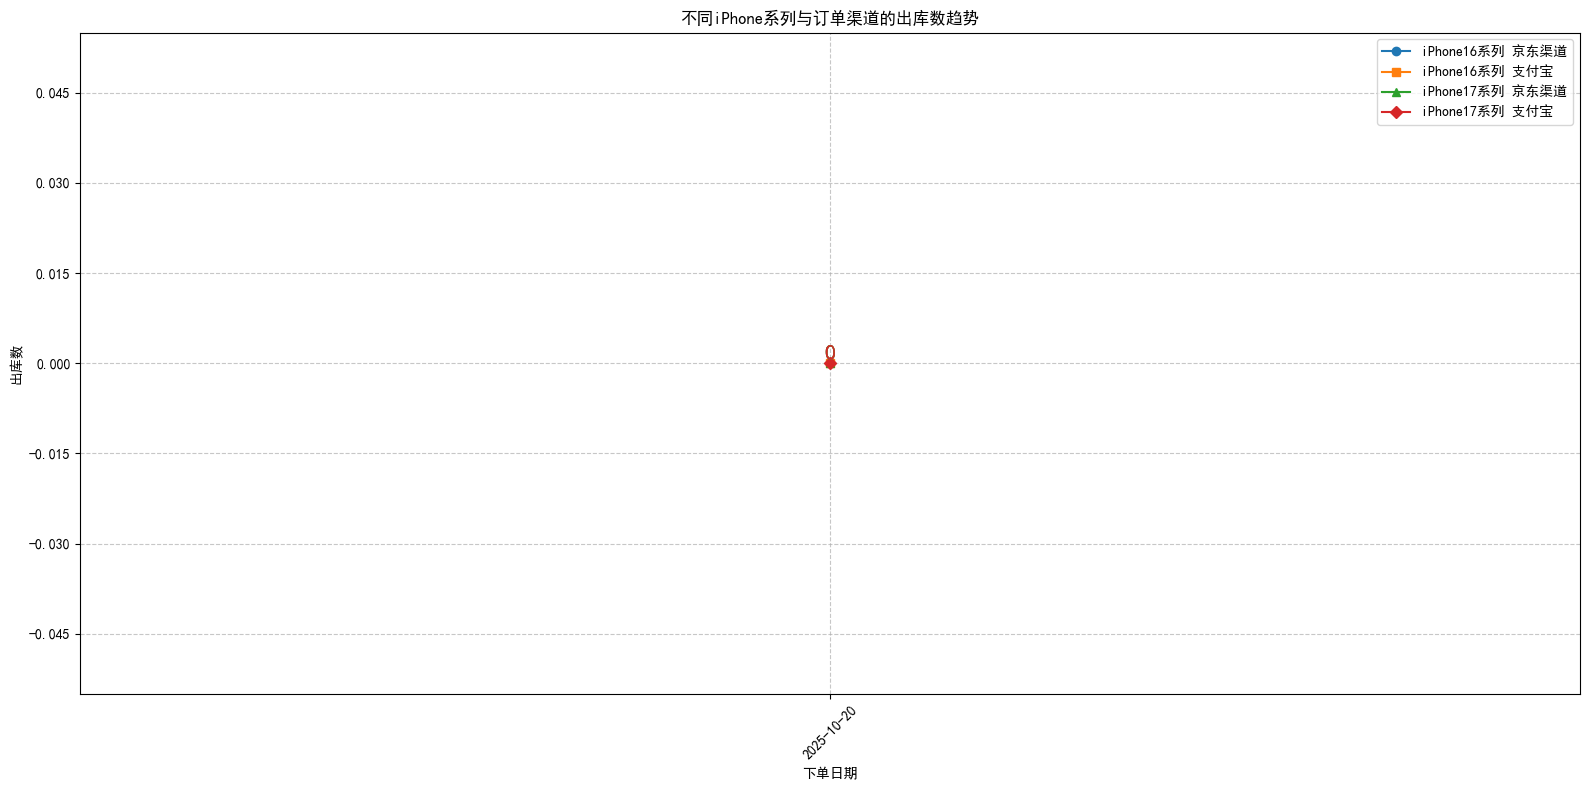

In [ ]:
### 步骤1：计算每日各分组的出库数（直接计数，非占比）
# 按「日期、iPhone系列、订单渠道」分组，统计出库数
daily_out_count = df_iphone.groupby(['下单日期', 'iPhone系列', '订单渠道'])['是否出库'].sum().reset_index()
daily_out_count.rename(columns={'是否出库': '出库数'}, inplace=True)

# 日期转为datetime类型
daily_out_count['下单日期'] = pd.to_datetime(daily_out_count['下单日期'])


### 步骤2：提取4个目标分组的出库数数据
group_jd_16_out = daily_out_count[
    (daily_out_count['iPhone系列'] == 'iPhone16系列') & (daily_out_count['订单渠道'] == '京东渠道')
]
group_alipay_16_out = daily_out_count[
    (daily_out_count['iPhone系列'] == 'iPhone16系列') & (daily_out_count['订单渠道'] == '支付宝')
]
group_jd_17_out = daily_out_count[
    (daily_out_count['iPhone系列'] == 'iPhone17系列') & (daily_out_count['订单渠道'] == '京东渠道')
]
group_alipay_17_out = daily_out_count[
    (daily_out_count['iPhone系列'] == 'iPhone17系列') & (daily_out_count['订单渠道'] == '支付宝')
]


### 步骤3：绘制出库数折线图（纵坐标为整数）
# 提取所有日期
all_dates_out = sorted(pd.to_datetime(daily_out_count['下单日期'].unique()))

plt.figure(figsize=(16, 8))  # 第二个图表：出库数

# 绘制4条出库数折线
line_jd16_out, = plt.plot(
    group_jd_16_out['下单日期'], group_jd_16_out['出库数'], 
    marker='o', label='iPhone16系列 京东渠道'
)
line_alipay16_out, = plt.plot(
    group_alipay_16_out['下单日期'], group_alipay_16_out['出库数'], 
    marker='s', label='iPhone16系列 支付宝'
)
line_jd17_out, = plt.plot(
    group_jd_17_out['下单日期'], group_jd_17_out['出库数'], 
    marker='^', label='iPhone17系列 京东渠道'
)
line_alipay17_out, = plt.plot(
    group_alipay_17_out['下单日期'], group_alipay_17_out['出库数'], 
    marker='D', label='iPhone17系列 支付宝'
)

# 纵坐标设置为整数
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# x轴显示所有日期
plt.xticks(all_dates_out, rotation=45)

# 为折线上的点添加出库数标签（整数格式）
def add_out_count_labels(x_dates, y_counts, line_obj, fmt='{:.0f}'):
    for x, y in zip(x_dates, y_counts):
        plt.text(
            x, y, fmt.format(y), 
            ha='center', va='bottom', 
            fontsize=16, color=line_obj.get_color()
        )

add_out_count_labels(group_jd_16_out['下单日期'], group_jd_16_out['出库数'], line_jd16_out)
add_out_count_labels(group_alipay_16_out['下单日期'], group_alipay_16_out['出库数'], line_alipay16_out)
add_out_count_labels(group_jd_17_out['下单日期'], group_jd_17_out['出库数'], line_jd17_out)
add_out_count_labels(group_alipay_17_out['下单日期'], group_alipay_17_out['出库数'], line_alipay17_out)

# 图表信息
plt.xlabel('下单日期')
plt.ylabel('出库数')
plt.title('不同iPhone系列与订单渠道的出库数趋势')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()  # 显示出库数图表